forward model: 

$$\frac{1}{f(w^Tx)}e^{(-\frac{1}{1 - f(w^Tx)}r_i)}$$



In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import toeplitz
import matplotlib.gridspec as gridspec
import itertools as it

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#rando parameters
T = 10000
n = 100
eps = 1e-3
c = 5

#stimulus
stim = np.random.normal(0, scale = 1, size = [T, n])

#feature space
#make weights gaussian

weights = 5*norm.pdf(range(0, n), loc = n/2, scale = 1)
#features = np.zeros((2, n))

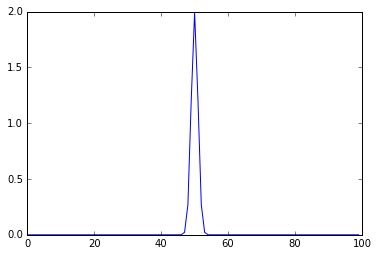

In [15]:
plt.plot(weights)

In [25]:
#stimulus based version

def gam_model(weights, stim):
    h = stim.dot(weights)
    f = np.exp(.5*h) 
    y = np.random.gamma(1, f)
    return y


y = gam_model(weights, stim)

ys = [gam_model(weights, stim) for i in range(500)]
#design = toeplitz(stim)


#fit the least squared filters, generate data from the fit
W_ls = np.linalg.pinv(stim).dot(y)
y_hats = [gam_model(W_ls, stim) for i in range(500)]
y_hatl = stim.dot(W_ls)

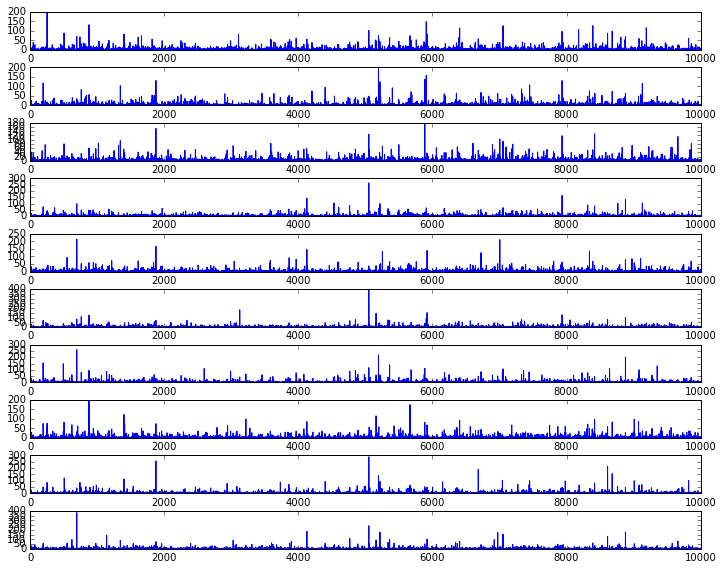

In [26]:
#visualize some traces 
num_rows, num_cols = 10, 1

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.0)

ax = [plt.subplot(gs[i]) for i in range(num_rows*num_cols)]
gs.update(hspace=1)
gs.tight_layout(fig, h_pad=0,w_pad=0)

for i,t in enumerate(ys[0:num_rows*num_cols]):
    ax[i].plot(t)
    #ax[i].axis('off')

plt.show()

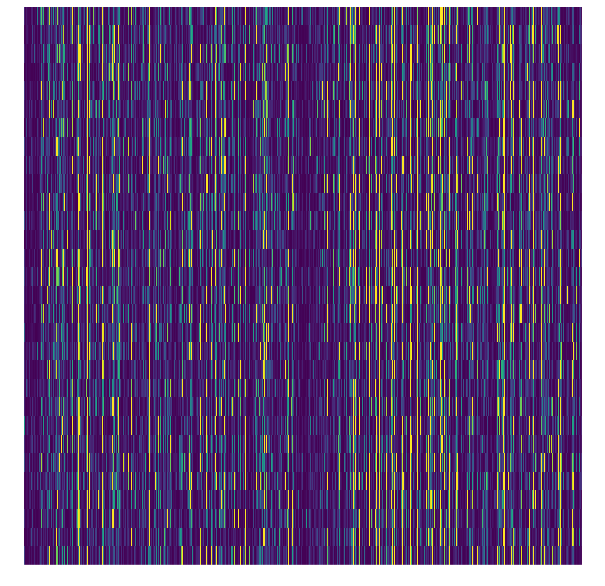

In [18]:
raster = np.array(ys)
plt.figure(figsize = [10, 10])
plt.imshow(raster[0:30, :], interpolation = 'none', cmap = 'viridis', aspect = 'auto', vmin = 0, vmax = 10)
plt.axis('off');

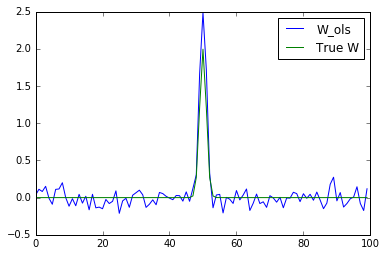

In [19]:
l1, = plt.plot(W_ls, 'b', label = 'W_ols')
l2, = plt.plot(weights, 'g', label = 'True W')
plt.legend(handles = [l1, l2])

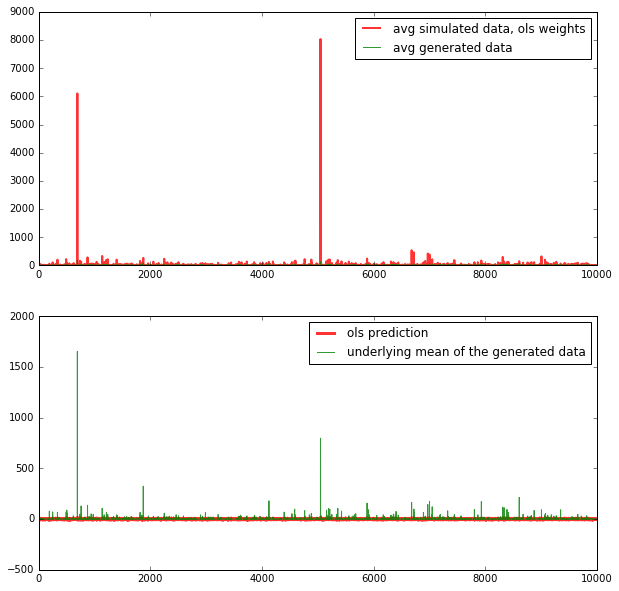

In [20]:
#_, f = gam_model(weights, stim)
h = stim.dot(weights)
f = np.exp(h-3) 

trial_av = np.average(ys, axis = 0)
trial_av2 = np.average(y_hats, axis =0)

plt.figure(figsize = [10, 10])


plt.subplot(211)
l2, = plt.plot(trial_av2, 'r', label = 'avg simulated data, ols weights', alpha = .8, linewidth = 2)
l1, = plt.plot(trial_av, 'g', label = 'avg generated data', alpha = .8)
#plt.ylim([0, 200])
plt.legend(handles = [l2, l1])
#plt.axis('off')

plt.subplot(212)
l3, = plt.plot(y_hatl, 'r', label = 'ols prediction', alpha = .8, linewidth = 3)
l4, = plt.plot(f, 'g', label = 'underlying mean of the generated data', alpha = .8)
#plt.ylim([0, 200])
plt.legend(handles = [l3, l4])
#plt.axis('off')


In [27]:
sess = tf.Session()

design = tf.placeholder('float32', shape = [None, n])
y_ = tf.placeholder('float32', shape = [None, 1])
w = tf.Variable(W_ls.reshape([n, 1]).astype('float32'), dtype = 'float32')

fx = tf.matmul(design, w) 

#dist_mean = tf.div(1.0,fx + eps)

exp = tf.mul(y_, tf.exp(fx + c))

loss = tf.reduce_sum(-fx + exp)

#grads = tf.convert_to_tensor( tf.concat(0, tf.gradients(loss, w)))

lr = .5e-3

train_step = tf.train.AdamOptimizer(lr).minimize(loss)
sess.run(tf.initialize_all_variables())

In [28]:
import pyprind 

batch_size = T
train_iters = 1000
loss_arr = []

bar = pyprind.ProgBar(train_iters, bar_char='█')

for i in range(train_iters):
    idx = np.random.randint(0, T, size = batch_size)
    
    train_feat = stim[idx] 
    train_obs = y[idx]
    bar.update()
    
    l, _ = sess.run([loss, train_step ], feed_dict = {design:train_feat, y_: train_obs[:, np.newaxis]})
    
    if i > 10:
        if (loss_arr[-1] - 1)**2 < eps:
            break
    
    #print l
    loss_arr.append(l)

0%                          100%
[██████████████████████████████] | ETA: 00:00:00
Total time elapsed: 00:00:14


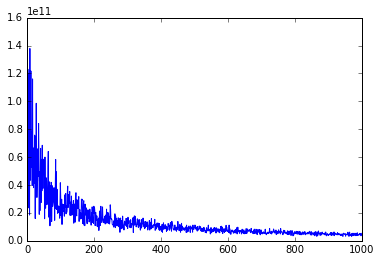

In [29]:
plt.plot(loss_arr)

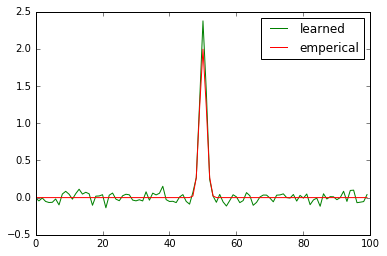

In [30]:
W_optim = sess.run(w)

l1, = plt.plot(W_optim, 'g', label = 'learned')
l2, = plt.plot(weights, 'r', label = 'emperical')

plt.legend(handles = [l1, l2])

In [31]:
import glm_model as gm

GLM = gm.exponential_GLM(n, W_ls.reshape([n, 1]).astype('float32'), max_iters = 1000)

In [32]:
l  = GLM.fit(stim, y)

0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:00:04


$$\sum_a^b(a+b)$$

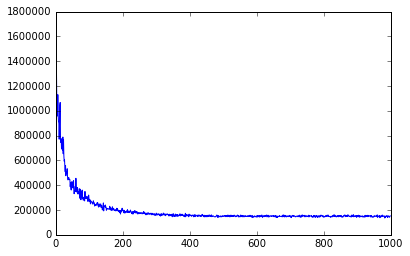

In [33]:
plt.plot(l)